<a href="https://colab.research.google.com/github/JuneSHYoo/monitory-ml/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# 데이터셋 불러오기

In [3]:
########################
###   데이터셋 불러오기   ###
########################

import pandas as pd

sensor_df = pd.read_csv('/content/drive/MyDrive/Factoreal/equipment_sensor_data.csv',encoding='utf-8-sig', header=0)
power_df = pd.read_csv('/content/drive/MyDrive/Factoreal/equipment_power_data.csv',encoding='utf-8-sig', header=0)

# 설비 센서 데이터셋

In [12]:
####################
###  설비 센서 데이터셋
#####################

# 사용할 컬럼만 추출
## 센서값, 설비(3종류), 이상여부
sensor_df = sensor_df[['temperature', 'pressure', 'vibration', 'humidity', 'equipment','faulty']]


# 인덱스를 새로운 컬럼으로 추가
sensor_df['idx'] = sensor_df.index

# 설비, 인덱스 기준으로 정렬
sensor_sorted = sensor_df.sort_values(['equipment','idx']).reset_index(drop=True)
sensor_sorted = sensor_sorted.drop(columns=['idx'])

In [17]:
# null 확인하기
print("✅ null 확인하기")
print(sensor_sorted.isnull().sum())

# 설비별 row수 확인하기
sensor_sorted.groupby('equipment').count()

✅ null 확인하기
temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
faulty         0
dtype: int64


,temperature,pressure,vibration,humidity,faulty
equipment,,,,,
Compressor,2573,2573,2573,2573,2573
Pump,2534,2534,2534,2534,2534
Turbine,2565,2565,2565,2565,2565


# 전력 센서 데이터셋

In [26]:
####################
###  전력 센서 데이터셋
#####################

# 사용할 컬럼만 추출
## 전력 센서값, 역률상태
power_df = power_df[['index','유효전력평균','무효전력평균','label_역률평균']]

# 한글 → 영문 레이블 변환 딕셔너리
label_map = {
    '경고': 'warn',
    '정상': 'normal',
    '주의': 'alert'
}

# 해당 컬럼명이 label_인 경우
power_df['label_elec'] = power_df['label_역률평균'].map(label_map)
power_df = power_df.drop(columns=['label_역률평균'])

power_df = power_df.rename(columns={
    '유효전력평균': 'active_power',
    '무효전력평균': 'reactive_power',
})

# active, reactive power 0인 데이터 지우기
power_df = power_df[power_df['active_power'] != 0]
power_df = power_df[power_df['reactive_power'] != 0]

In [30]:
# 전력 상태 비율 확인하기
print("✅ 전력 상태 비율 확인하기")
print(power_df['label_elec'].value_counts())
print("✅ 전력 상태 비율 확인하기 (정규화)")
print(power_df['label_elec'].value_counts(normalize=True))

✅ 전력 상태 비율 확인하기
label_elec
normal    1315163
warn       208676
alert      154119
Name: count, dtype: int64
✅ 전력 상태 비율 확인하기 (정규화)
label_elec
normal    0.783788
warn      0.124363
alert     0.091849
Name: proportion, dtype: float64


# 설비센서*전력 데이터셋 병합하기

In [60]:
##############################
###  설비센서*전력 데이터셋 병합하기
##############################

## 첫번째 설비
## Compressor
## 총 2573개

N = 2573

# 1. 상태별 비율 계산
ratio = power_df['label_elec'].value_counts(normalize=True)

# 2. 상태비율별 추출 샘플수 계산
stratify_num = (ratio * N).round().astype(int)

# 3. 상태별로 샘플링 후 Merge
sampled_list = []
for label, cnt in stratify_num.items():
    label_rows = power_df[power_df['label_elec'] == label]
    sampled = label_rows.sample(n=cnt, replace=True, random_state = 42)
    sampled_list.append(sampled)

sampled_power_01 = pd.concat(sampled_list).sort_index().reset_index(drop=True)
sampled_power_01 = sampled_power_01.iloc[:N].reset_index(drop=True)

# 4. 센서 데이터에도 인덱스 reset
sampled_sensor_01 = sensor_sorted[sensor_sorted['equipment'] == 'Compressor'].reset_index(drop=True)

# 5. 인덱스 기준 1:1 concat
merged_comp = pd.concat([sampled_sensor_01.reset_index(drop=True), sampled_power_01.reset_index(drop=True)], axis=1)
merged_comp = merged_comp.drop(columns=['index'])
merged_comp

,temperature,pressure,vibration,humidity,equipment,faulty,active_power,reactive_power,label_elec
0,75.740712,22.954018,2.338095,41.867407,Compressor,0.0,70726.0,43564.00,normal
1,49.510959,76.426729,4.809298,20.269692,Compressor,1.0,6812.0,3045.75,normal
2,66.903503,45.530759,1.548345,64.804922,Compressor,0.0,24991.0,18531.00,normal
3,63.886148,33.802912,1.139280,41.795515,Compressor,0.0,96976.0,47212.00,normal
4,53.070432,44.105203,2.071652,47.458742,Compressor,0.0,33839.0,14597.00,normal
...,...,...,...,...,...,...,...,...,...
2568,54.493366,44.791491,1.806078,57.952672,Compressor,0.0,157072.0,50876.00,normal
2569,76.082462,29.745316,1.621451,50.153066,Compressor,0.0,35436.0,95340.00,warn
2570,73.503702,37.736796,0.739279,61.241768,Compressor,0.0,-2840.0,5700.00,warn
2571,69.587073,45.760937,1.269738,60.915675,Compressor,0.0,62120.0,29008.00,normal


In [72]:
##############################
###  설비센서*전력 데이터셋 병합하기
##############################

## 두번째 설비
## Pump
## 총 2534

N = 2534

# 1. 상태별 비율 계산
ratio = power_df['label_elec'].value_counts(normalize=True)

# 2. 상태비율별 추출 샘플수 계산
stratify_num = (ratio * N).round().astype(int)

# 3. 상태별로 샘플링 후 Merge
sampled_list = []
for label, cnt in stratify_num.items():
    label_rows = power_df[power_df['label_elec'] == label]
    sampled = label_rows.sample(cnt, replace=True, random_state = 23)
    sampled_list.append(sampled)

sampled_power_02 = pd.concat(sampled_list).sort_index().reset_index(drop=True)
sampled_power_02 = sampled_power_02.iloc[:N].reset_index(drop=True)

# 4. 센서 데이터에도 인덱스 reset
sampled_sensor_02 = sensor_sorted[sensor_sorted['equipment'] == 'Pump'].reset_index(drop=True)

# 5. 인덱스 기준 1:1 concat
merged_pump = pd.concat([sampled_sensor_02.reset_index(drop=True), sampled_power_02.reset_index(drop=True)], axis=1)
merged_pump = merged_pump.drop(columns=['index'])
merged_pump

,temperature,pressure,vibration,humidity,equipment,faulty,active_power,reactive_power,label_elec
0,71.616985,32.242921,1.770690,40.565138,Pump,0.0,35512.00,20212.00,normal
1,66.506832,45.197471,0.345398,43.253795,Pump,0.0,18226.00,29221.00,warn
2,50.403299,45.399899,2.231718,43.067667,Pump,0.0,13798.50,20678.25,warn
3,141.260310,54.239058,2.725691,86.390466,Pump,1.0,36596.00,24744.00,normal
4,57.903053,30.368126,1.652980,48.857561,Pump,0.0,24465.00,27874.00,alert
...,...,...,...,...,...,...,...,...,...
2529,76.141667,35.465702,1.803365,53.247433,Pump,0.0,98260.00,47848.00,normal
2530,69.055413,29.357466,1.496698,59.257625,Pump,0.0,29735.00,21592.00,normal
2531,65.711521,37.505934,2.030521,49.331471,Pump,0.0,197472.00,26440.00,normal
2532,63.005855,45.164234,1.264585,61.905390,Pump,0.0,6986.75,2991.50,normal


In [73]:
##############################
###  설비센서*전력 데이터셋 병합하기
##############################

## 세번째 설비
## Turbine
## 총 2565

N = 2565

# 1. 상태별 비율 계산
ratio = power_df['label_elec'].value_counts(normalize=True)

# 2. 상태비율별 추출 샘플수 계산
stratify_num = (ratio * N).round().astype(int)

# 3. 상태별로 샘플링 후 Merge
sampled_list = []
for label, cnt in stratify_num.items():
    label_rows = power_df[power_df['label_elec'] == label]
    sampled = label_rows.sample(cnt, replace=True)
    sampled_list.append(sampled)

sampled_power_03 = pd.concat(sampled_list).sort_index().reset_index(drop=True)
sampled_power_03 = sampled_power_03.iloc[:N].reset_index(drop=True)

# 4. 센서 데이터에도 인덱스 reset
sampled_sensor_03 = sensor_sorted[sensor_sorted['equipment'] == 'Turbine'].reset_index(drop=True)

# 5. 인덱스 기준 1:1 concat
merged_turb = pd.concat([sampled_sensor_03.reset_index(drop=True), sampled_power_03.reset_index(drop=True)], axis=1)
merged_turb = merged_turb.drop(columns=['index'])
merged_turb

,temperature,pressure,vibration,humidity,equipment,faulty,active_power,reactive_power,label_elec
0,58.180180,25.029278,0.606516,45.694907,Turbine,0.0,94104.00,39700.0,normal
1,71.358594,27.276830,1.389198,58.954409,Turbine,0.0,27284.00,18275.0,normal
2,148.923369,22.214121,0.109819,39.944953,Turbine,1.0,13201.00,13406.5,alert
3,84.711703,44.084965,1.359403,47.560971,Turbine,0.0,1764.00,1291.0,normal
4,83.736585,53.447573,1.643008,25.525049,Turbine,0.0,28181.00,14946.0,normal
...,...,...,...,...,...,...,...,...,...
2560,56.518230,43.456472,0.844428,56.114135,Turbine,0.0,384.00,7728.0,warn
2561,71.396537,27.255896,1.918917,65.060127,Turbine,0.0,37950.00,10082.0,normal
2562,64.259174,32.131660,1.874060,39.069232,Turbine,0.0,59200.00,25470.0,normal
2563,62.179965,36.422638,1.565271,51.606218,Turbine,0.0,18355.75,22667.0,warn


In [74]:
##############################
###  설비센서*전력 데이터셋 병합하기
##############################

## Merge
merged_df = pd.concat([merged_comp, merged_pump, merged_turb], ignore_index=True)
merged_df

,temperature,pressure,vibration,humidity,equipment,faulty,active_power,reactive_power,label_elec
0,75.740712,22.954018,2.338095,41.867407,Compressor,0.0,70726.00,43564.00,normal
1,49.510959,76.426729,4.809298,20.269692,Compressor,1.0,6812.00,3045.75,normal
2,66.903503,45.530759,1.548345,64.804922,Compressor,0.0,24991.00,18531.00,normal
3,63.886148,33.802912,1.139280,41.795515,Compressor,0.0,96976.00,47212.00,normal
4,53.070432,44.105203,2.071652,47.458742,Compressor,0.0,33839.00,14597.00,normal
...,...,...,...,...,...,...,...,...,...
7667,56.518230,43.456472,0.844428,56.114135,Turbine,0.0,384.00,7728.00,warn
7668,71.396537,27.255896,1.918917,65.060127,Turbine,0.0,37950.00,10082.00,normal
7669,64.259174,32.131660,1.874060,39.069232,Turbine,0.0,59200.00,25470.00,normal
7670,62.179965,36.422638,1.565271,51.606218,Turbine,0.0,18355.75,22667.00,warn


In [76]:
merged_df.groupby('label_elec')["faulty"].value_counts()

label_elec  faulty
alert       0.0        633
            1.0         72
normal      0.0       5407
            1.0        606
warn        0.0        865
            1.0         89
Name: count, dtype: int64

In [78]:
###################################
###  잔존수명(RUL) - target data 생성
###################################

import pandas as pd
import numpy as np

df = merged_df.copy()

# ① 이벤트 정의 (예시: faulty==1 또는 label_elec in ['alert', 'warn'])
df['event'] = (df['faulty'] == 1) | (df['label_elec'].isin(['alert']))

# ② RUL 초기화
df['rul'] = 0

# ③ 설비별 RUL 계산 (equipment별)
for equip, sub_df in df.groupby('equipment'):
    idx = sub_df.index.values
    event_idx = sub_df[sub_df['event']].index.values

    if len(event_idx) == 0:
        # event가 없으면 해당 설비 구간 RUL=길이
        df.loc[idx, 'rul'] = len(sub_df)
    else:
        pos = np.searchsorted(event_idx, idx, side='left')
        rul_vals = np.zeros_like(idx)
        for i, p in enumerate(pos):
            if p < len(event_idx):
                rul_vals[i] = event_idx[p] - idx[i]
            else:
                rul_vals[i] = 0  # event 이후는 0
        df.loc[idx, 'rul'] = rul_vals

# 결과 확인
print(df[['equipment', 'temperature', 'pressure', 'vibration', 'humidity', 'faulty','active_power', 'reactive_power','label_elec','rul']].head(20))


     equipment  temperature   pressure  vibration   humidity  faulty  \
0   Compressor    75.740712  22.954018   2.338095  41.867407     0.0   
1   Compressor    49.510959  76.426729   4.809298  20.269692     1.0   
2   Compressor    66.903503  45.530759   1.548345  64.804922     0.0   
3   Compressor    63.886148  33.802912   1.139280  41.795515     0.0   
4   Compressor    53.070432  44.105203   2.071652  47.458742     0.0   
5   Compressor    68.491623  45.438678   1.195049  59.989678     0.0   
6   Compressor    81.663705  21.754885   1.202416  47.006730     0.0   
7   Compressor    67.419915  31.181241   1.469402  40.993603     0.0   
8   Compressor    74.070523  48.903880   0.923370  50.287287     0.0   
9   Compressor    73.376027  24.216034   0.865038  59.741185     0.0   
10  Compressor    65.212414  47.837880   0.845611  45.036369     0.0   
11  Compressor    55.364851  41.281481   0.452781  23.994641     0.0   
12  Compressor    76.728612  45.775530   1.313841  51.154359    

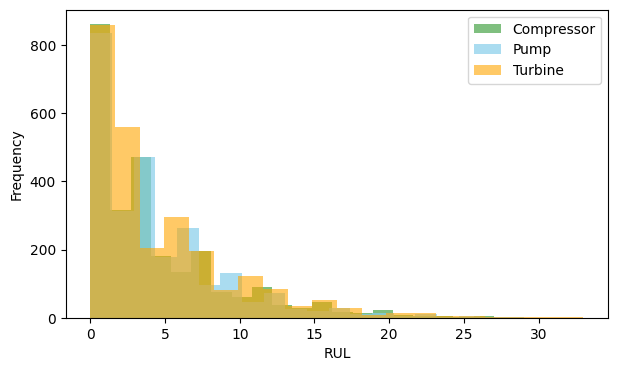

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(df[df['equipment'] == "Compressor"]['rul'],alpha=0.5, label = 'Compressor',bins=20,color='green')
plt.hist(df[df['equipment'] == "Pump"]['rul'],alpha=0.7, label = 'Pump',bins=20,color='skyblue')
plt.hist(df[df['equipment'] == "Turbine"]['rul'],alpha=0.6, label = 'Turbine',bins=20,color='orange')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [92]:
## 훈련용 데이터 저장
df.to_csv("train_equips_data.csv",index=False, encoding="utf-8")